# 实验四  朴素贝叶斯

## 数据集
Most Popular Data Set中的wine数据集（对意大利同一地区声场的三种不同品种的酒做大量分析所得出的数据）

## 基本要求
采用分层采样的方式将数据集划分为训练集和测试集。 
给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。
## 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。
## 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。
## 拓展要求
浅谈ROC曲线和AUC值作为分类评价的合理性。


## 一. 基本要求

### 1. 导入数据集

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt

f = open('wine.data', 'r')
types = [[], [], []]                      # 按类分的所有数据
test_data = [[], [], []]
train_data = [[], [], []]
data_num = 0                            # 数据总数
test_len = []                           # 测试集里每一类的个数
means = [[], [], []]                      # 每一类的均值
std = [[], [], []]                        # 每一类的标准差
myline = '1'
while myline:
    myline = f.readline().split(',')
    if len(myline) != 14:
        break
    for t in range(len(myline)):
        if t == 0:
            myline[t] = int(myline[t])
        else:
            myline[t] = float(myline[t])
    temp = myline.pop(0)
    types[temp - 1].append(myline)
test_len = [round(len(types[i]) / 10) for i in range(3)]
data_num = sum([len(types[i]) for i in range(3)])
y_test=[]   # 保存测试集属性
y_pred_test=[]   # 保存测试集真实类别
y_pred_score=[]

In [23]:
y_test=[]   # 保存测试集属性
y_pred_test=[]   # 保存测试集真实类别
y_pred_score=[]

### 2. 构建朴素贝叶斯分类器

In [9]:
def bayes_classificate(train_data, test_data):
    for i in range(3):
        means[i] = np.mean(train_data[i], axis=0)        # 分别计算三个类别的均值
        std[i] = np.std(train_data[i], axis=0)           # 这里是标准差
    wrong_num = 0
    for i in range(3):
        for t in test_data[i]:                  # 两层循环：从每一类取每一个测试样本
            my_type = []
            y_score=[]
            for j in range(3):
                # 由于数据集中所有的属性都是连续值，连续值的似然估计可以按照高斯分布来计算：
                temp = np.log((2*math.pi) ** 0.5 * std[j])
                temp += np.power(t - means[j], 2) / (2 * np.power(std[j], 2))
                temp = np.sum(temp)
                temp = -1*temp+math.log(len(types[j])/data_num)
                my_type.append(temp)                        # 这里将所有score保存
            pre_type = my_type.index(max(my_type))          # 取分值最大的为预测类别
            my_type.append(i)
            y_pred_score.append(my_type)
            
            y_pred_test.append(pre_type)
            if pre_type != i:                               # 统计错误数
                wrong_num += 1
    return wrong_num

### 3. 分层抽样与分类

In [25]:
wrong_num = 0

for i in range(10): 
    for j in range(3):
        # 分层抽样
        if (i+1)*test_len[j] > len(types[j]):
            test_data[j] = np.mat(types[j][i*test_len[j]:])
            train_data[j] = np.mat(types[j][:i*test_len[j]])
        else:
            test_data[j] = np.mat(types[j][i*test_len[j]:(i+1)*test_len[j]])
            train_data[j] = np.mat(types[j][:i*test_len[j]]+types[j][(i+1)*test_len[j]:])
            
    # 数据带入朴素贝叶斯分类器
    wrong_num += bayes_classificate(train_data, test_data)
print("分类准确率: "+str(1-wrong_num/data_num))

分类准确率: 0.9775280898876404


## 二. 中级要求

### 1. 计算混淆矩阵

In [11]:
def cal_confusion(y_test,y_pred_test):
    confusion = np.zeros((3,3))
    for i in range(len(y_test)):
        confusion[y_test[i]][y_pred_test[i]] += 1
    confusion=np.array(confusion)
    return confusion

### 2. 根据混淆矩阵进行精度、召回率和F值的计算

In [12]:
con_mat = cal_confusion(y_test, y_pred_test)
print("混淆矩阵为：\n",con_mat)

precision = []  #保存精度
recall = []     #保存召回率
F1_score = []  # 保存F值

# 计算精度
for i in range(3):
    precision.append(round(con_mat[i][i]/np.sum(con_mat,axis=0)[i],2))
# 计算召回率
for i in range(3):
    recall.append(round(con_mat[i][i]/np.sum(con_mat,axis=1)[i],2))
# 计算F值
for i in range(3):
    F1_score.append(round(2*precision[i]*recall[i]/(precision[i]+recall[i]),2))
# 计算support值
support = np.sum(con_mat,axis=1)

print("           precision     recall    f1-score    support")
for i in range(3):
    print("{}\t      {}\t   {}\t      {}\t   {}\t".format(i+1,precision[i],recall[i],F1_score[i],int(support[i])))
print("macro avg:    {}\t   {}\t      {}\t   {}\t".format(round(np.sum(precision)/len(types),2),
round(np.sum(recall)/len(types), 2), round(np.sum(F1_score)/len(types), 2), int(np.sum(con_mat))))

混淆矩阵为：
 [[57.  2.  0.]
 [ 0. 68.  2.]
 [ 0.  0. 48.]]
           precision     recall    f1-score    support
1	      1.0	   0.97	      0.98	   59	
2	      0.97	   0.97	      0.97	   70	
3	      0.96	   1.0	      0.98	   48	
macro avg:    0.98	   0.98	      0.98	   177	


## 三. 高级要求

### 1. 定义roc_curve()函数

In [17]:
def roc_curve(scores, label):
    # 初始化空列表来存储假正例率（FPR）和真正例率（TPR）
    fpr = []
    tpr = []

    # 将正类别（positive）和负类别（negative）的样本分开
    p_s = [i for i in scores if i[3] == label]  # 正类别样本
    n_s = [i for i in scores if i[3] != label]  # 负类别样本

    # 计算正类别和负类别样本的数量
    postive_num = len(p_s)
    negative_num = len(n_s)

    # 对每个分数阈值计算对应的 FPR 和 TPR
    for i in scores:
        threshold = i[label]
        fp_num = 0  # 假正例数量
        tp_num = 0  # 真正例数量

        # 计算在当前阈值下，正类别样本和负类别样本的 FPR 和 TPR
        for j in p_s:
            if j[label] >= threshold:
                tp_num += 1
        for j in n_s:
            if j[label] >= threshold:
                fp_num += 1

        # 计算并添加 FPR 和 TPR 到对应的列表
        fpr.append(fp_num / negative_num)
        tpr.append(tp_num / postive_num)

    # 添加 (0,0) 到 ROC 曲线的末尾，表示 FPR 和 TPR 均为零
    fpr.append(0)
    tpr.append(0)

    # 计算曲线下面积（AUC）
    auc = 0.0
    for i in p_s:
        for j in n_s:
            if i[label] > j[label]:
                auc += 1
            elif i[label] == j[label]:
                auc += 0.5
    auc /= (postive_num * negative_num)  # 归一化 AUC 值

    # 返回 FPR 列表、TPR 列表和计算出的 AUC 值
    return fpr, tpr, auc


### 2. 计算每个类别的fpr、tpr和auc

In [18]:
# 计算每一类的ROC和AUC
fpr = dict()
tpr = dict()
auc = dict()
for i in range(len(types)):
    score_sort = sorted(y_pred_score, key=lambda x: x[i])
    fpr[i], tpr[i], auc[i] = roc_curve(score_sort, i)
    print("第{}类红酒AUC值为{}".format(i, auc[i]))

第0类红酒AUC值为0.9948290721057167
第1类红酒AUC值为0.9337783711615487
第2类红酒AUC值为0.9925710594315246


### 3. 绘制ROC图像

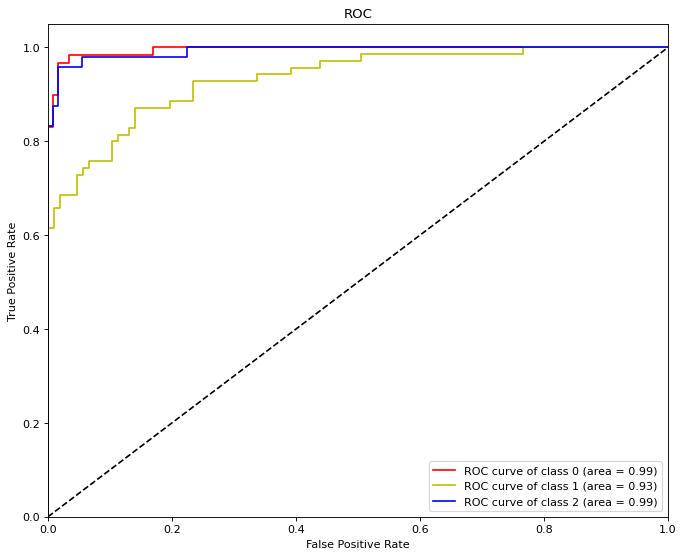

In [19]:
plt.figure(figsize=(10,8),dpi=80)
colors = ['r', 'y', 'b']
for i, color in zip(range(len(types)), colors):
    plt.plot(fpr[i], tpr[i], color=color,label='ROC curve of class {0} (area = {1:0.2f})'.format(i, auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## 拓展要求
### 合理性：

#### ROC曲线的合理性：

不受类别分布影响： ROC曲线不受不平衡类别分布的影响，因此适用于不平衡数据集，其中正例和负例的数量差距较大。

可视化分类器性能： ROC曲线提供了分类器在不同阈值下的性能可视化，帮助用户根据应用需求选择合适的阈值。

无需知道类别分布： ROC曲线的绘制不需要了解正例和负例的先验分布，仅依赖分类器的输出分数。
#### AUC值的合理性：

数值化性能： AUC值是ROC曲线下面积的度量，提供了分类器性能的单个数值评估，方便比较不同分类器的性能。

概率解释： AUC值可以解释为从随机选择正例和负例样本时，分类器正确分类的概率。AUC值越接近1，分类器性能越好。

### 限制和注意事项：

#### ROC曲线的限制：

不考虑类别概率： ROC曲线不考虑分类器输出的概率值，而只关注排序。因此，如果应用需要考虑概率信息，可能需要其他评估指标。

不适用于多类别问题： ROC曲线通常用于二元分类问题，不直接适用于多类别问题。在多类别问题中，可以使用One-Versus-Rest (OvR) ROC曲线。

#### AUC值的限制：

不敏感于类别分布： AUC值不敏感于正例和负例的比例，这可以是优点，但也可能隐藏问题。在极不平衡的数据集中，AUC值可能高，但分类器的性能不一定好。

不考虑阈值选择： AUC值不考虑阈值的选择，而是整体性能的度量。在某些应用中，阈值的选择可能非常重要。